# ML Lab Internship (Nov '20) **Round 1 Task 1**

In [1]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git    #cloning the repository
%cd covid-chestxray-dataset 

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3614 (delta 7), reused 11 (delta 5), pack-reused 3599
Receiving objects: 100% (3614/3614), 633.00 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (1430/1430), done.
Checking out files: 100% (1173/1173), done.
/content/covid-chestxray-dataset


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import cv2
import os

The dataset given to us contains the X-ray and CT images of patients which are positive or suspected of COVID-19 or other viral and bacterial pneumonias (MERS, SARS, and ARDS.)

**For classification, we need two types of input.**


*   **Covid19 detected/suspected patient's Xrays.**
*   **Other Viral/bacterial pneumonia affected patient's Xray.
So that we can have a proper classification.**

**Having normal people's Xray would have made the classifcation better but that is not present in the provided dataset.**



# Image Gathering the two different types of X-rays and CT scan

In [3]:
data = pd.read_csv("metadata.csv")  #reading the data and storing it

In [4]:
data.head() #seeing our dataframe

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [5]:
data.columns #getting to know all our columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')

**After thorough research the column descriptions are as follows:**

* Patientid (internal identifier, just for this dataset)
* offset (number of days since the start of symptoms or hospitalization for each image, this is very important to have when there are multiple images for the same patient to track progression while being imaged. If a report says "after a few days" let's assume 5 days.)
* sex (M, F, or blank)
* age (age of the patient in years)
* finding (which pneumonia)
* survival (did they survive? Y or N)
* view (for example, PA, AP, or L for X-rays and Axial or Coronal for CT scans)
* modality (CT, X-ray, or something else)
* date (date the image was acquired)
* location (hospital name, city, state, country) importance from right to left.
* filename
* doi (DOI of the research article)
* url (URL of the paper or website where the image came from)
* license
* clinical notes (about the radiograph in particular, not just the patient)
* other notes (e.g. credit)




In [6]:
#dropping the column named Unnamed: 29'
data.drop(columns='Unnamed: 29',inplace=True)
data.shape

(950, 29)

In [7]:
#getting to know the different values in finding column and its number representation
data['finding'].value_counts()

Pneumonia/Viral/COVID-19                   584
todo                                        83
Pneumonia                                   81
Pneumonia/Fungal/Pneumocystis               30
Pneumonia/Bacterial/Streptococcus           22
No Finding                                  22
Tuberculosis                                18
Pneumonia/Viral/SARS                        16
Pneumonia/Lipoid                            13
Pneumonia/Bacterial/Mycoplasma              11
Pneumonia/Bacterial/Klebsiella              10
Pneumonia/Bacterial/Legionella              10
Pneumonia/Viral/MERS-CoV                    10
Pneumonia/Bacterial/Nocardia                 8
Pneumonia/Viral/Varicella                    6
Pneumonia/Viral/Influenza                    5
Pneumonia/Bacterial/E.Coli                   4
Pneumonia/Bacterial                          4
Pneumonia/Viral/Herpes                       3
Pneumonia/Bacterial/Chlamydophila            3
Pneumonia/Fungal/Aspergillosis               2
Pneumonia/Vir

In [8]:
#getting to know the different values in view column and its number representation
data['view'].value_counts()

PA           344
AP Supine    234
AP           203
L             84
Axial         68
Coronal       16
AP Erect       1
Name: view, dtype: int64

**Storing the two different types of patient's images in a particular folder**

In [9]:
TARGET_DIR1 ="Dataset"  #creating a new directory

if not os.path.exists(TARGET_DIR1):
  os.mkdir(TARGET_DIR1)
  print("Directory created")

Directory created


In [10]:
TARGET_DIR ="Dataset/covid"     #creating a folder in the directory

if not os.path.exists(TARGET_DIR):
  os.mkdir(TARGET_DIR)
  print("Folder for Covid created")

Folder for Covid created


In [11]:
TARGET_DIR2 ="Dataset/notcovid"     #creating a folder in the directory

if not os.path.exists(TARGET_DIR2):
  os.mkdir(TARGET_DIR2)
  print("Folder for Covid created")

Folder for Covid created


In [12]:
# loop over the rows of the COVID-19 data frame
for (i, row) in data.iterrows():

    if row["finding"] != "Pneumonia/Viral/COVID-19" and row['view']=="PA": #PA in Xray stands for posterioranterior view (front view)
        filename = row['filename']
        # build the path to the input image file
        image_path = os.path.join("images",filename)
        img_copy_path = os.path.join(TARGET_DIR2,filename)

    elif row["finding"] == "Pneumonia/Viral/COVID-19" and row["view"] == "PA":  #we will accept only the front view of the Xray of the covid patients

        filename = row['filename']
        # build the path to the input image file
        image_path = os.path.join("images",filename)
        img_copy_path = os.path.join(TARGET_DIR,filename)

    elif not os.path.exists(image_path):
        continue

    # copy the image
    shutil.copy2(image_path, img_copy_path)

# Now PLotting the images

In [13]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(25,8), rows=1, titles=None, maintitle=None):

    f = plt.figure(figsize=figsize)
    if maintitle is not None: 
      plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: 
          sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [14]:
from imutils import paths
normal_images = list(paths.list_images(f"Dataset/notcovid"))
covid_images = list(paths.list_images(f"Dataset/covid"))

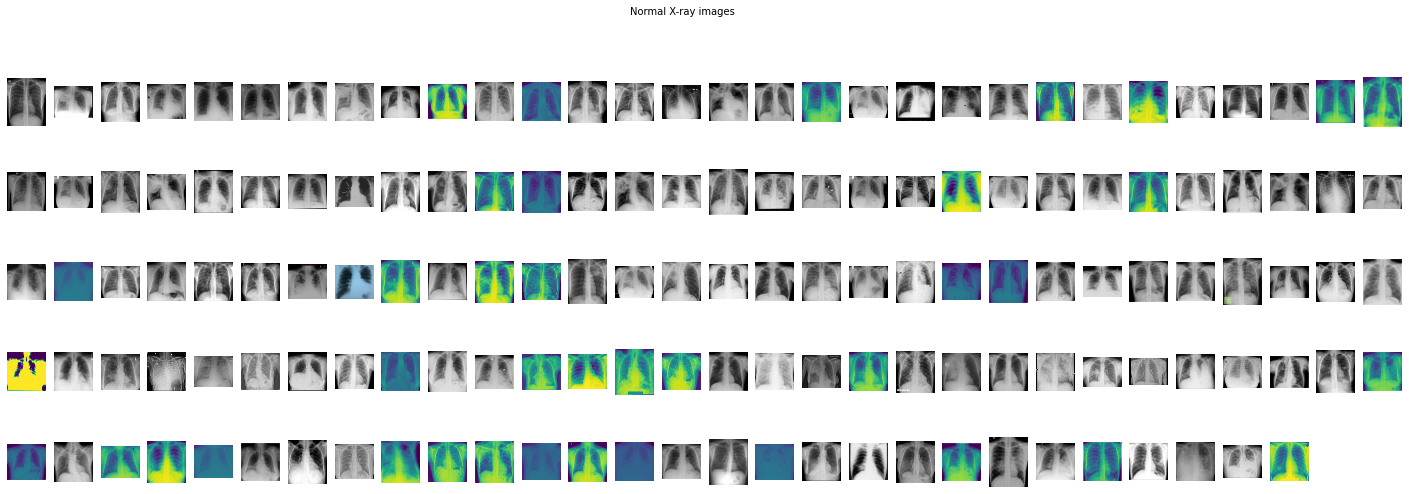

In [15]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

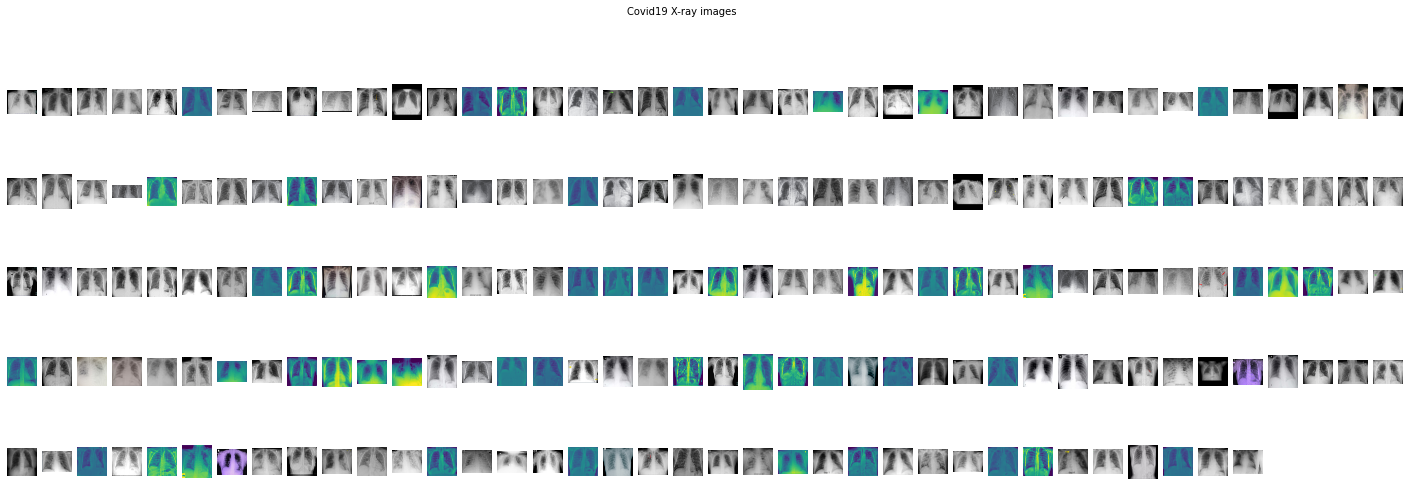

In [16]:
plots_from_files(covid_images, rows=5, maintitle="Covid19 X-ray images")

# Data Preprocessing

In [17]:
# initialize the initial learning rate, number of epochs to train and batch size
INIT_LR = 1e-3
EPOCHS = 150
BS = 8

In [18]:
# getting the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images

imagePaths = list(paths.list_images("Dataset"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [19]:
data.shape

(344, 224, 224, 3)

In [20]:
labels.shape

(344,)

In [21]:
# perform one-hot encoding on the labels

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

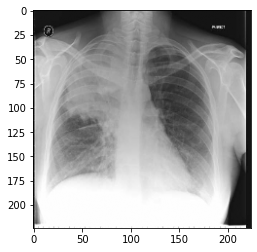

In [22]:
plt.imshow(data[1])

# MODEL

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import random

In [24]:
# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


# TRAINING

In [25]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# training the head of the network
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
34/34 [==============================] - 4s 114ms/step - loss: 0.8377 - accuracy: 0.5581 - val_loss: 0.7415 - val_accuracy: 0.5652
Epoch 2/150
34/34 [==============================] - 3s 88ms/step - loss: 0.7425 - accuracy: 0.5281 - val_loss: 0.6711 - val_accuracy: 0.5652
Epoch 3/150
34/34 [==============================] - 3s 87ms/step - loss: 0.6597 - accuracy: 0.5955 - val_loss: 0.6674 - val_accuracy: 0.6377
Epoch 4/150
34/34 [==============================] - 3s 86ms/step - loss: 0.6703 - accuracy: 0.5843 - val_loss: 0.6654 - val_accuracy: 0.5362
Epoch 5/150
34/34 [==============================] - 3s 86ms/step - loss: 0.6444 - accuracy: 0.6554 - val_loss: 0.6605 - val_accuracy: 0.5507
Epoch 6/150
34/34 [==============================] - 3s 86ms/step - loss: 0.6294 - accuracy: 0.6592 - val_loss: 0.6554 - val_accuracy: 0.5797
Epoch 7/150
34/34 [==============================] - 3s 87ms/step - los

# Plotting the result

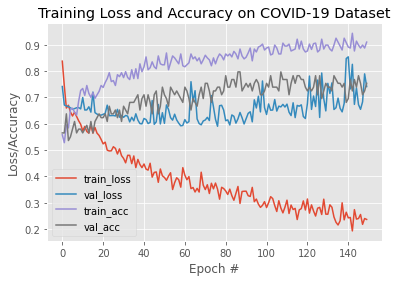

In [26]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# Evaluation

In [27]:
# make predictions on the testing set

predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.73      0.90      0.80        39
    notcovid       0.81      0.57      0.67        30

    accuracy                           0.75        69
   macro avg       0.77      0.73      0.74        69
weighted avg       0.76      0.75      0.74        69



In [28]:
# compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[35  4]
 [13 17]]
acc: 0.7536
sensitivity: 0.8974
specificity: 0.5667


# Conclusion

**For medical science, having the best accuracy should be our priority and for that we need the correct sample of data.**

Here in this scenario **the accuracy we achieved, can be made better by increasing the no. of epochs and decresing our learning rate. But in that case, the chance of the model getting overfitted would have been there.**

**Problem in this case was Data** mainly. **The dataset provided to us was patients who was suffering from viral/bacterial pneumonia. The dataset didn't have the images of a normal patient. Thus the model is finding it to difficult to find the distinguising pattern from the images that can classify the image as "Covid" or  "Not Covid".**

**Having the images of a normal patient would have made the classification result more reliable and accurate.**